In [3]:
import os
import pandas as pd
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from google.colab import files

uploaded = files.upload()

Saving fasttext.pickle to fasttext.pickle


In [5]:
df = pd.read_pickle('fasttext.pickle')

In [6]:
df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,"[0.025498182, -0.018170398, 0.046447996, -0.02...",2024-10-09,5,54,0,0,0
1,1,"[0.011105347, -0.008842508, 0.021998996, 0.018...",2024-10-09,5,195,0,0,0
2,2,"[0.013566197, 0.004024408, 0.029151376, -0.037...",2024-10-09,5,17,0,0,0
3,3,"[0.004013102, -0.0022078655, 0.0066413223, 0.0...",2024-10-09,5,33,0,0,0
4,4,"[0.071841806, 0.012794206, 0.05186933, -0.0082...",2024-10-09,5,15,0,0,0


In [7]:
del df['Review date']

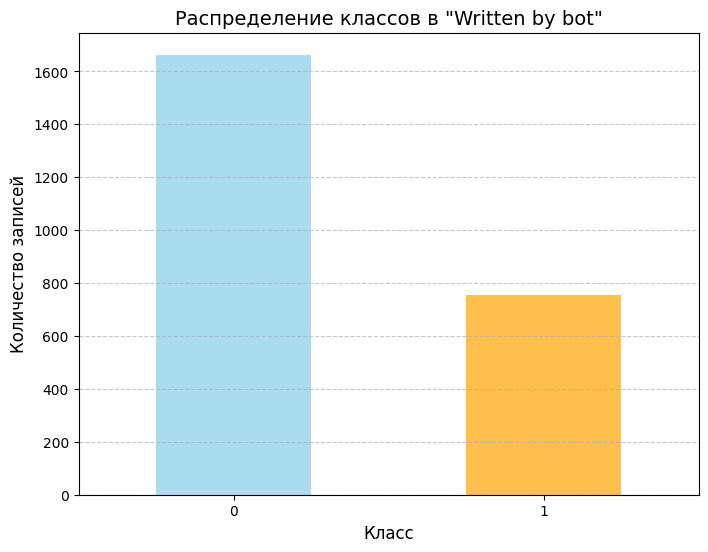

In [8]:
df_balance = df.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')

In [10]:
df['Has media'] = df['Has media'].replace({'True': '1', 'False': '0'})
df['Has media'].value_counts()

,count
Has media,
0,1699
1,717


In [11]:
y = df['Written by bot']
X = df.drop(columns=['Written by bot']).values

In [12]:
y, X = df['Written by bot'], df.drop(columns=['Written by bot'])

Исходное распределение классов: Counter({0: 1663, 1: 753})


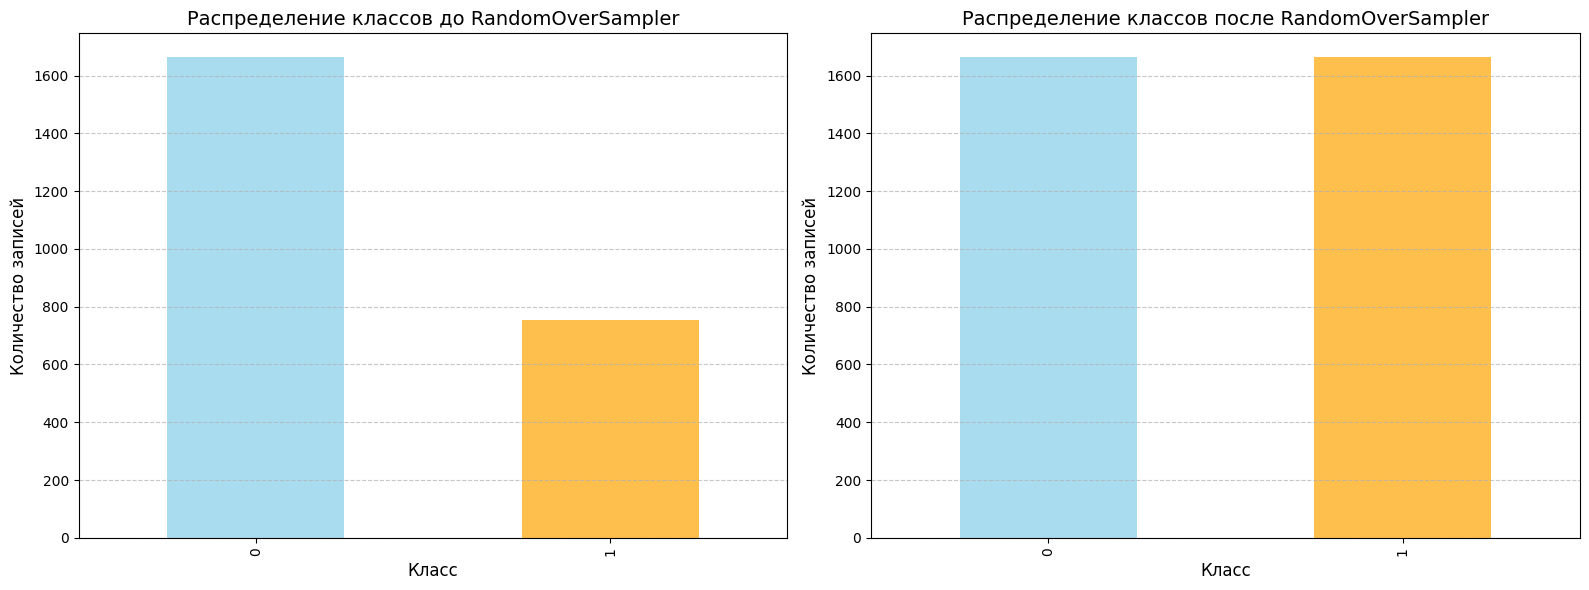

In [13]:
print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [14]:
import tensorflow as tf
X_ros_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)
X_ros_df['User review'] = X_ros_df['User review']
X_ros_text = X_ros_df['User review']
X_ros_text = np.array(X_ros_text.tolist(), dtype=np.float32)
X_ros_text_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_ros_text, maxlen=1000, padding='post', truncating='post'
)
X_ros_numeric = X_ros_df.drop(columns=['User review'])
X_ros_numeric = np.array(X_ros_numeric, dtype=np.float32)

In [15]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_ros_text, X_ros_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2660, 300), X_test_text: (666, 300)
Размеры числовых данных:
X_train_num: (2660, 4), X_test_num: (666, 4)
Размеры меток:
y_train: (2660,), y_test: (666,)


In [16]:
X_train_text = tf.convert_to_tensor(X_train_text, dtype=tf.float32)
X_train_num = tf.convert_to_tensor(X_train_num, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

X_test_text = tf.convert_to_tensor(X_test_text, dtype=tf.float32)
X_test_num = tf.convert_to_tensor(X_test_num, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [17]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [19]:
import keras_tuner as kt

In [24]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]  # EarlyStopping при поиске
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]  # EarlyStopping при обучении
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model1.h5")

Trial 26 Complete [00h 00m 11s]
val_accuracy: 0.6876876950263977

Best val_accuracy So Far: 0.7732732892036438
Total elapsed time: 00h 07m 12s
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5530 - loss: 21.7345 - val_accuracy: 0.4985 - val_loss: 11.7287
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5464 - loss: 10.3205 - val_accuracy: 0.5661 - val_loss: 5.4374
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5845 - loss: 4.8751 - val_accuracy: 0.6577 - val_loss: 3.4788
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6290 - loss: 3.3244 - val_accuracy: 0.7643 - val_loss: 2.8207
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7077 - loss: 2.7286 - val_accuracy: 0.7417 - val_loss: 2.4070
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7258 - loss: 2.3782 - val_accuracy: 0.7748 - val_loss: 2.1302
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7587 - loss: 2.0686 - val_accuracy

Тестовая точность: 0.7808


# Pooling

In [25]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)
    x_text = GlobalAveragePooling1D()(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model2.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4708 - loss: 1.6239 - val_accuracy: 0.7387 - val_loss: 1.2520
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5569 - loss: 1.1868 - val_accuracy: 0.7793 - val_loss: 0.9416
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6815 - loss: 0.9031 - val_accuracy: 0.7868 - val_loss: 0.7887
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7193 - loss: 0.7699 - val_accuracy: 0.7087 - val_loss: 0.7214
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7301 - loss: 0.7136 - val_accuracy: 0.7838 - val_loss: 0.6678
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8018 - loss: 0.6547 - val_accuracy: 0.8529 - val_loss: 0.6050
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8471 - loss: 0.5939 - val_accuracy: 0.8694 - val_loss: 0.5395
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

Тестовая точность: 0.9474


# LSTM

In [26]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)
    x_text = LSTM(hp.Int('lstm_units', 32, 256, 32), return_sequences=False)(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model_lstm.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5405 - loss: 12.1376 - val_accuracy: 0.8348 - val_loss: 6.4131
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8554 - loss: 5.0802 - val_accuracy: 0.9129 - val_loss: 2.0456
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9130 - loss: 1.5193 - val_accuracy: 0.9309 - val_loss: 0.5624
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9387 - loss: 0.5056 - val_accuracy: 0.9339 - val_loss: 0.4199
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9385 - loss: 0.4181 - val_accuracy: 0.9429 - val_loss: 0.3613
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9440 - loss: 0.3617 - val_accuracy: 0.9459 - val_loss: 0.3257
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9576 - loss: 0.3106 - val_accuracy: 0.9625 - val_loss: 0.2894
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s

Тестовая точность: 0.9730


# GRU

In [27]:
def build_model(hp):
    text_input = Input(shape=(300,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)
    x_text = GRU(hp.Int('gru_units', 32, 256, 32), return_sequences=False)(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model_gru.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4450 - loss: 12.2924 - val_accuracy: 0.8529 - val_loss: 6.5942
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7519 - loss: 5.2420 - val_accuracy: 0.9084 - val_loss: 2.1081
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9041 - loss: 1.5996 - val_accuracy: 0.9414 - val_loss: 0.6075
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9190 - loss: 0.5763 - val_accuracy: 0.9384 - val_loss: 0.4445
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9314 - loss: 0.4501 - val_accuracy: 0.9550 - val_loss: 0.3704
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9474 - loss: 0.3778 - val_accuracy: 0.9610 - val_loss: 0.3262
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9518 - loss: 0.3413 - val_accuracy: 0.9610 - val_loss: 0.3033
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s

Тестовая точность: 0.9655
